## <font color=blue> HiCAT example usage  </font>
####  Machine Learning and Bioinformatics (MLBI) Lab @ DKU, 2022.07.27 <br>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import cm

## import HiCAT

In [2]:
from MarkerCount.hicat import HiCAT, show_summary 

https://github.com/combio-dku


## Load single-cell data

In [31]:
file = 'Melanoma_5K_rev'
adata_t = sc.read_h5ad(file + '.h5ad')
adata_t

AnnData object with n_obs × n_vars = 4513 × 23684
    obs: 'tumor', 'malignant', 'cell_type', 'broad_cell_type', 'sample_name', 'celltype', 'celltype_major', 'celltype_minor', 'cluster', 'HiCAT_subset', 'HiCAT_minor', 'HiCAT_major', 'scSorter_major', 'scSorter_minor', 'Garnett_major', 'Garnett_minor', 'SCINA_major', 'SCINA_minor', 'DigitalCellSorter_subset', 'DigitalCellSorter_minor', 'DigitalCellSorter_major', 'scType_major', 'scType_minor', 'scCatch_major', 'scCatch_minor', 'pid', 'scType_subset', 'scCatch_subset', 'SCINA_subset', 'Garnett_subset', 'scSorter_subset'
    var: 'gene_name'
    uns: 'HiCAT_result', 'HiCAT_summary'

### Run HiCAT

In [32]:
## Marker file to use
mkr_file = 'cell_markers_rndsystems_rev.tsv'

df_pred, summary = \
    HiCAT( adata_t.to_df(), marker_file = mkr_file, log_transformed = False,
                   Clustering_algo = 'lv', Clustering_resolution = 1, 
                   Target_FPR = 0.05, pval_th = 0.05,
                   target_cell_types = [], ## all in the db
                   minor_types_to_exclude = [], N_neighbors_minor = 31,
                   N_neighbors_subset = 11, cycling_cell = False, 
                   verbose = False )

adata_t.obs['HiCAT_cluster'] = df_pred['cluster']
adata_t.obs['HiCAT_subset'] = df_pred['cell_type_subset']
adata_t.obs['HiCAT_minor'] = df_pred['cell_type_minor']
adata_t.obs['HiCAT_major'] = df_pred['cell_type_major']

HiCAT running .......... done. (27)


## Compare performance (Major-type annotation)

In [33]:
## For performance evaluation
def get_perf_ext( df_pred, cell_types_not_consider, truth = 'cell_type_true' ):
    
    cell_type = df_pred[truth]
    bc = np.full(len(cell_type), False)
    for ct in cell_types_not_consider:
        bc = bc | (cell_type == ct)
    df_pred = df_pred.loc[~bc,:]
        
    cols = list(df_pred.columns.values)
    if 'target_cell_types' in cols:
        cols.remove('target_cell_types')
    if truth in cols:
        cols.remove(truth)
    
    df_perf = pd.DataFrame(index = ['C', 'CUA', 'EUA', 'EA', 'E'])
    tcts = list(set(df_pred['target_cell_types']))
    
    bt = np.full( df_pred.shape[0], False )
    for k, tct in enumerate(tcts):
        b1 = df_pred['target_cell_types'] == tct
        tct_lst = tct.split(',')
        for ct in tct_lst:
            b2 = df_pred[truth] == ct
            bt = bt | (b1&b2)
                
    bz = df_pred[truth] != 'Unknown'
    df_perf['ideal'] = [np.sum(bz&bt)/np.sum(bz), \
                        np.sum(bz&(~bt))/np.sum(bz), 0,0,0]
        
    for c in cols:
        tcol = c        
        ba = np.full( df_pred.shape[0], False )
        for k, tct in enumerate(tcts):
            b1 = df_pred['target_cell_types'] == tct
            tct_lst = tct.split(',')
            for ct in tct_lst:
                b2 = df_pred[tcol] == ct
                ba = ba | (b1&b2)                
        bua = ~ba
        b_cua = ((bz) & (~bt) & (bua))
        b_ea = ((bz) & (~bt) & (ba))
        b_eua = ((bz) & (bt) & (bua))
        b_e = ((bz) & (bt) & (~bua) & (df_pred[tcol] != df_pred[truth]))
        b_c = ((bz) & (bt) & (~bua) & (df_pred[tcol] == df_pred[truth]))
        
        n_correctly_unassigned = np.sum(b_cua)/np.sum(bz)
        n_incorrectly_assigned = np.sum(b_ea)/np.sum(bz)
        n_incorrectly_unassigned = np.sum(b_eua)/np.sum(bz)
        n_incorrect = np.sum(b_e)/np.sum(bz)
        n_correct = np.sum(b_c)/np.sum(bz)
        
        df_perf[c] = [n_correct, n_correctly_unassigned, n_incorrectly_unassigned, \
                      n_incorrectly_assigned, n_incorrect]

    df_perf = df_perf*100
    df_perf = df_perf.loc[['C', 'EUA', 'E', 'EA', 'CUA'],:]
    df_perf.loc['Method',:] = list(df_perf.columns.values)
    df_perf = df_perf.T

    return df_perf

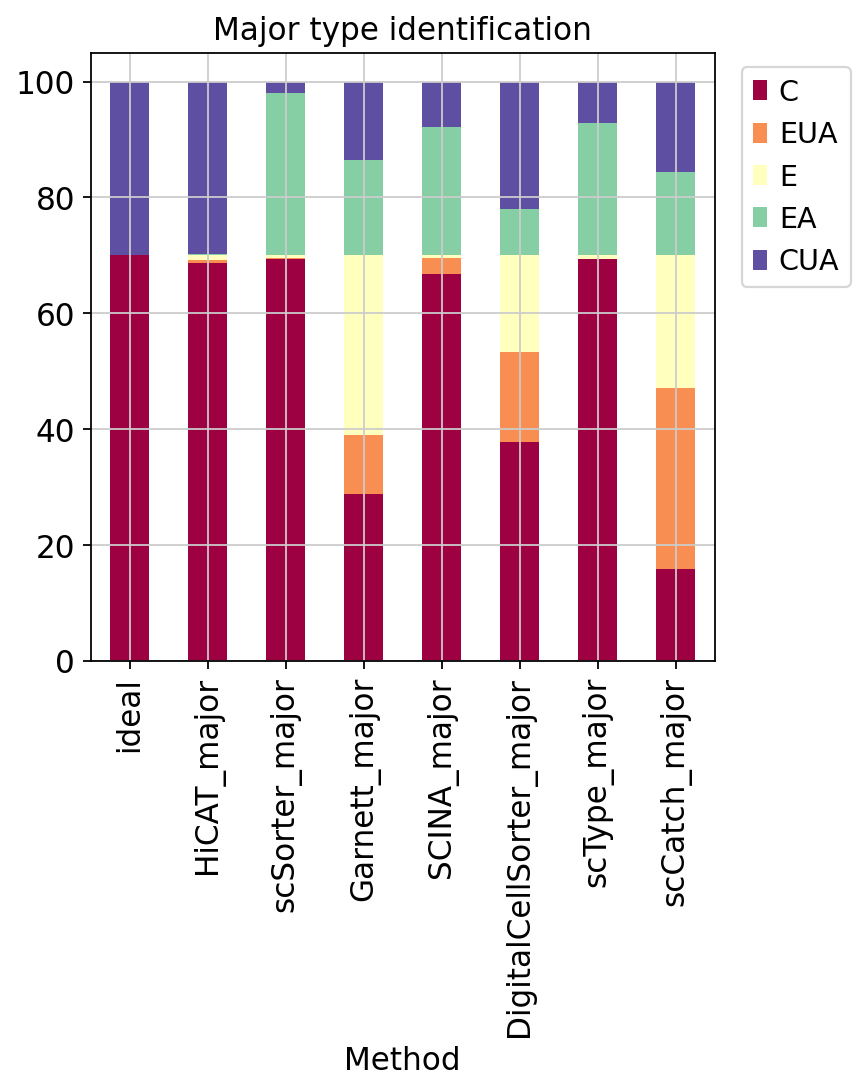

In [34]:
from MarkerCount.hicat import get_markers_major_type, get_markers_cell_type

## Get target major cell-types 
mkr_lst_pos, mkr_lst_neg = get_markers_major_type(mkr_file)
target_cell_types = list(mkr_lst_pos.keys())

## Columns to select from adata_t.obs
cols = ['celltype', 'HiCAT', 'scSorter', 'Garnett', 
            'SCINA', 'DigitalCellSorter', 'scType', 'scCatch']
cols_sel = [c + '_major' for c in cols]

## Get columns & set target cell-types
df_pred_all = adata_t.obs[cols_sel].astype(str)
df_pred_all['target_cell_types'] = ','.join(target_cell_types)

## Get performances
df_perf = get_perf_ext( df_pred_all, cell_types_not_consider = ['Unknown'], 
                                    truth = cols_sel[0])

ax = df_perf.plot( x = 'Method', kind = 'bar', stacked = True, title = 'Major type identification', \
                       cmap = cm.get_cmap('Spectral'), legend = False )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') # , title = 'legend')
plt.show()

## Compare performance (Minor-type annotation)

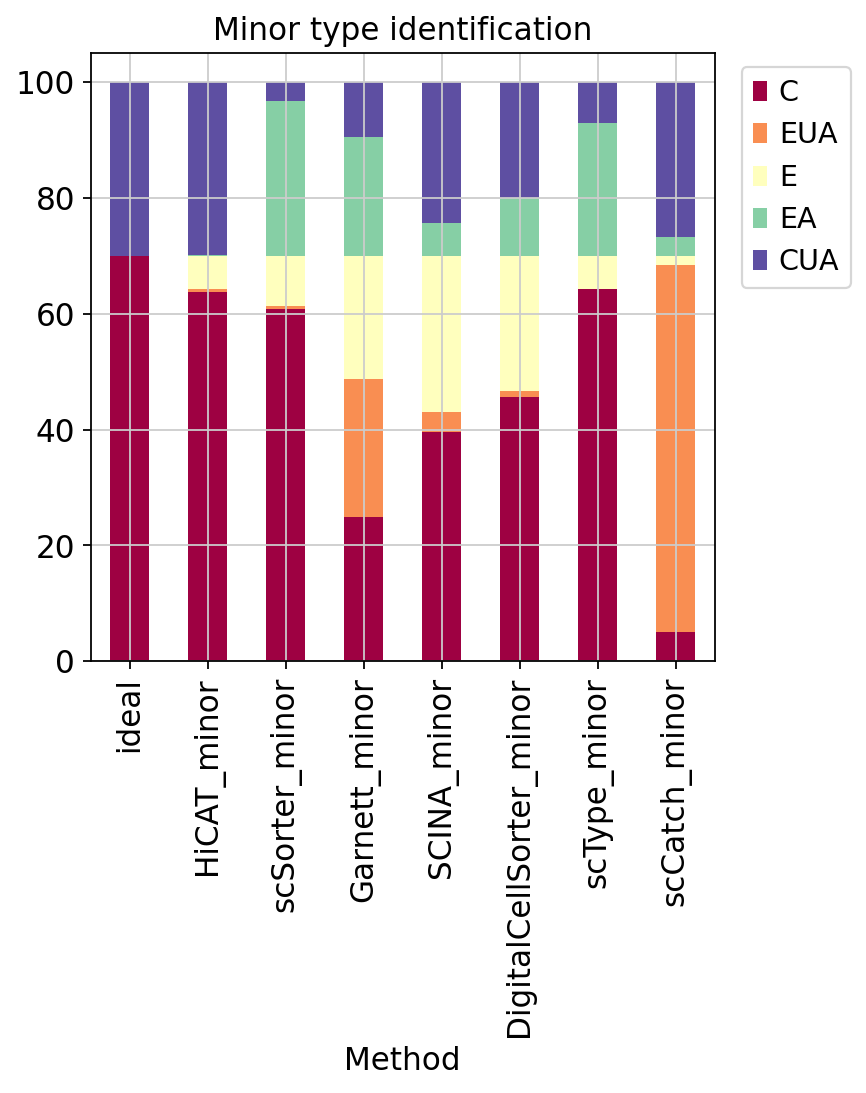

In [35]:
## Get target minor cell-types 
mkr_lst_pos, mkr_lst_neg = get_markers_cell_type(mkr_file)
target_cell_types = list(mkr_lst_pos.keys())

## Columns to select from adata_t.obs
cols = ['celltype', 'HiCAT', 'scSorter', 'Garnett', 
            'SCINA', 'DigitalCellSorter', 'scType', 'scCatch']
cols_sel = [c + '_minor' for c in cols]

## Get columns & set target cell-types
df_pred_all = adata_t.obs[cols_sel].astype(str)
df_pred_all['target_cell_types'] = ','.join(target_cell_types)

## Get performances
df_perf = get_perf_ext( df_pred_all, cell_types_not_consider = ['Unknown'], 
                                    truth = cols_sel[0])

ax = df_perf.plot( x = 'Method', kind = 'bar', stacked = True, title = 'Minor type identification', \
                       cmap = cm.get_cmap('Spectral'), legend = False )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') # , title = 'legend')
plt.show()

## Check UMAP

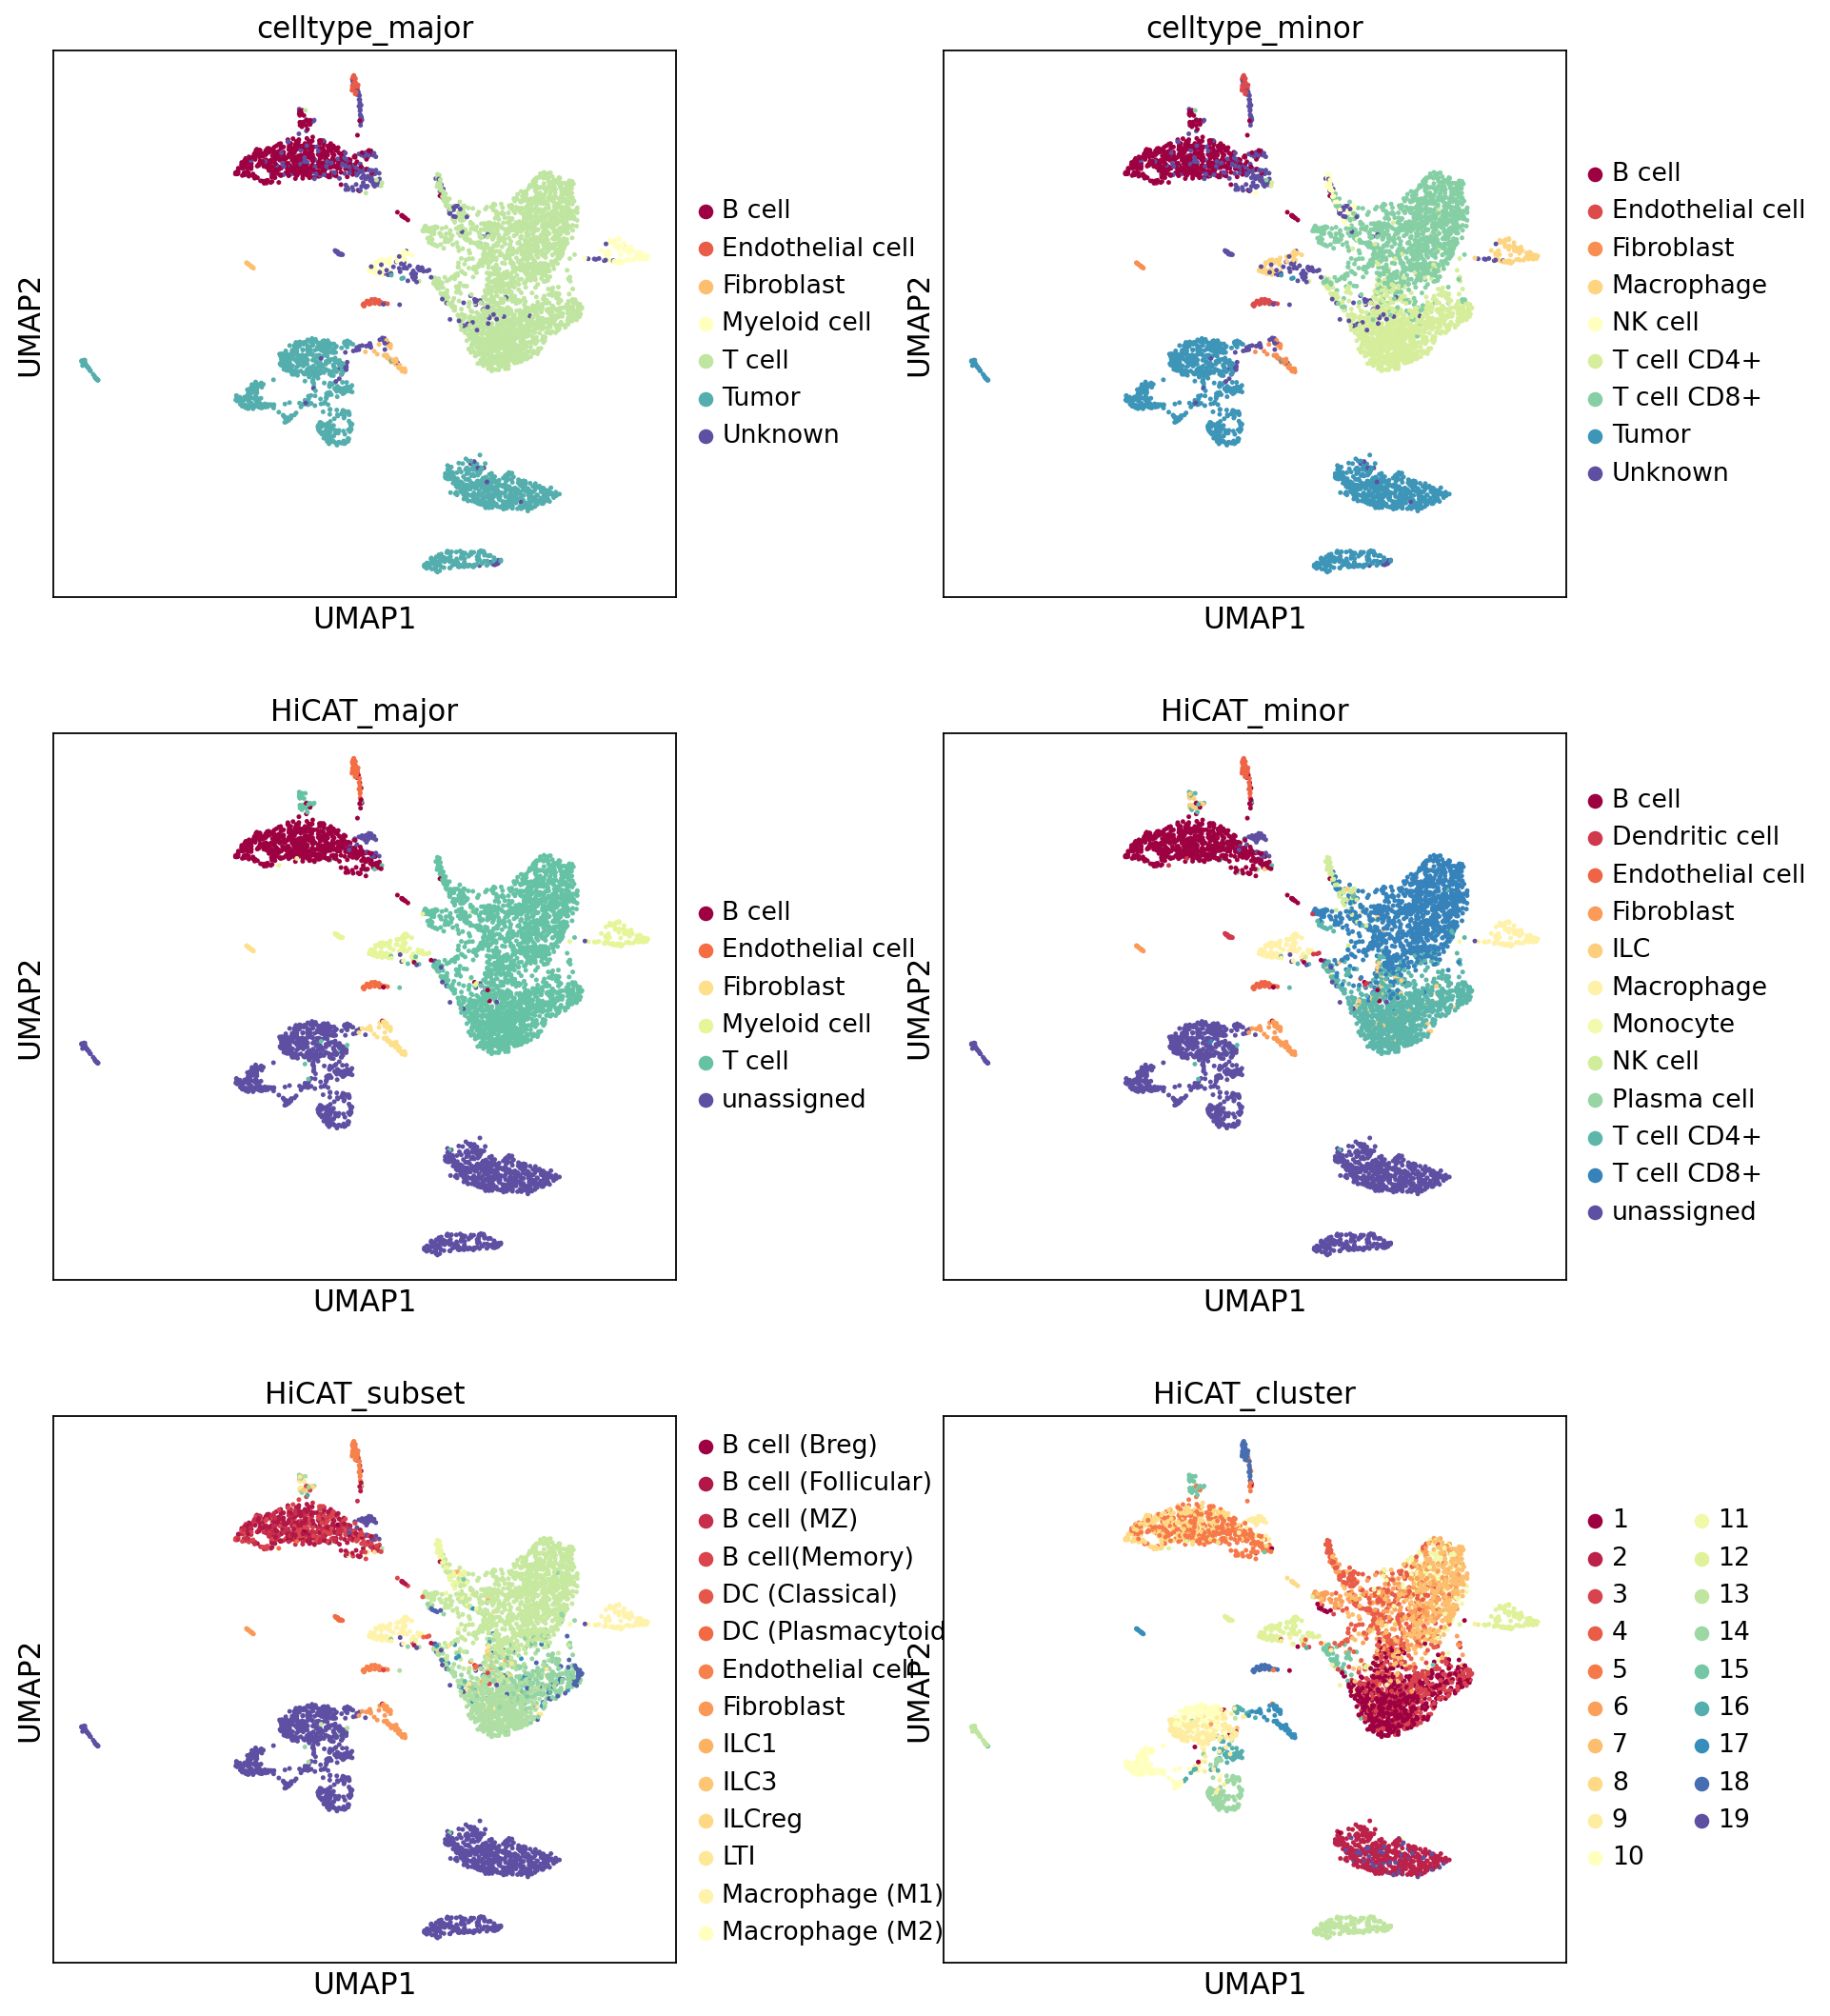

In [36]:
## Normalize and log-transform
sc.pp.normalize_total(adata_t, target_sum=1e4)
sc.pp.log1p(adata_t)
sc.pp.highly_variable_genes(adata_t, n_top_genes = 2000) 
sc.pp.scale(adata_t, max_value=10)

N_pca = 15
sc.tl.pca(adata_t, svd_solver='arpack', n_comps = N_pca, use_highly_variable = True)
sc.pp.neighbors(adata_t, n_neighbors=10, n_pcs=N_pca)
sc.tl.leiden(adata_t, resolution = 1)
sc.tl.umap(adata_t)   

c_target = ['celltype_major', 'celltype_minor',
            'HiCAT_major', 'HiCAT_minor', 'HiCAT_subset', 'HiCAT_cluster'] # , 

sc.settings.set_figure_params(figsize=(5, 5), dpi=80, facecolor='white')
sc.pl.umap(adata_t, color=c_target, wspace = 0.3, \
           s = 20, legend_fontsize = 12, title = c_target, ncols = 2, 
           palette = 'Spectral') 

## Check HiCAT summary

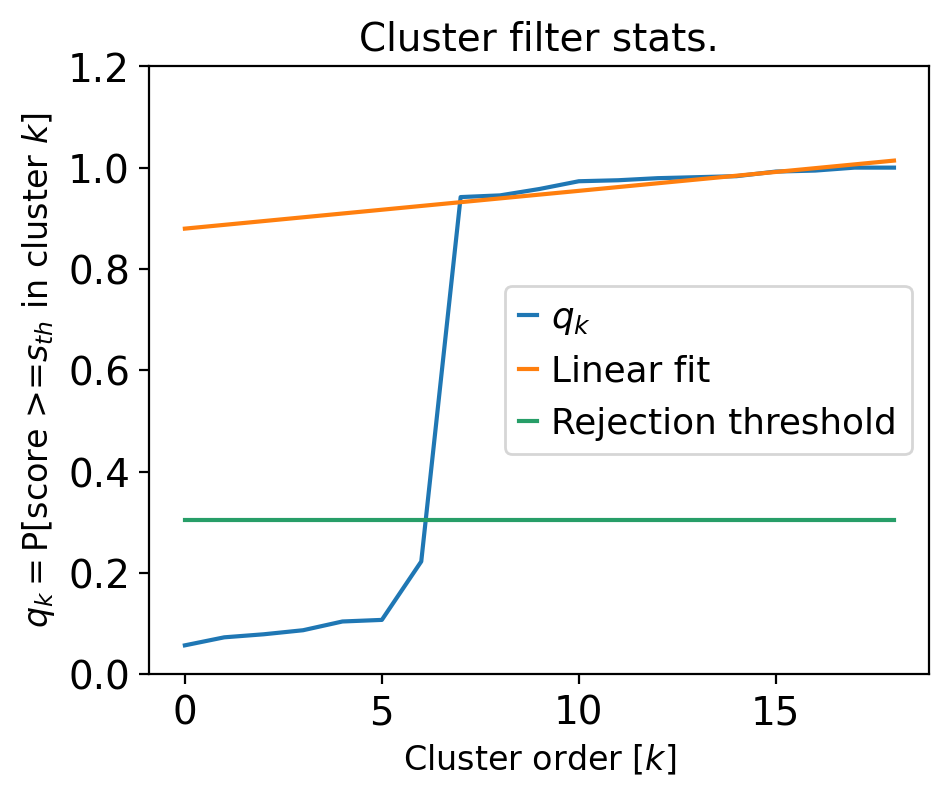

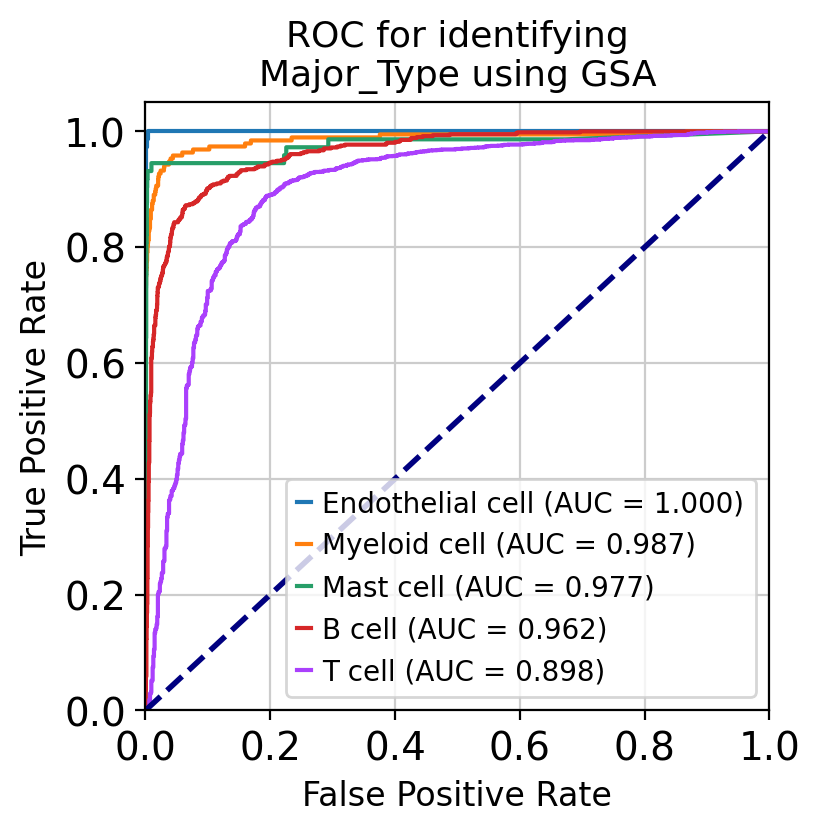

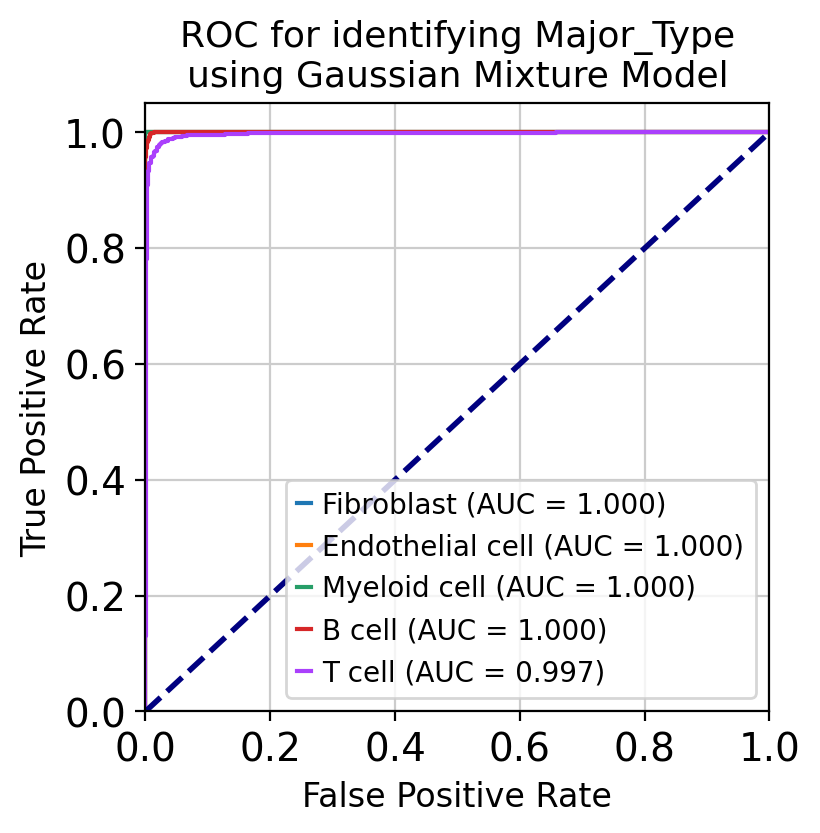

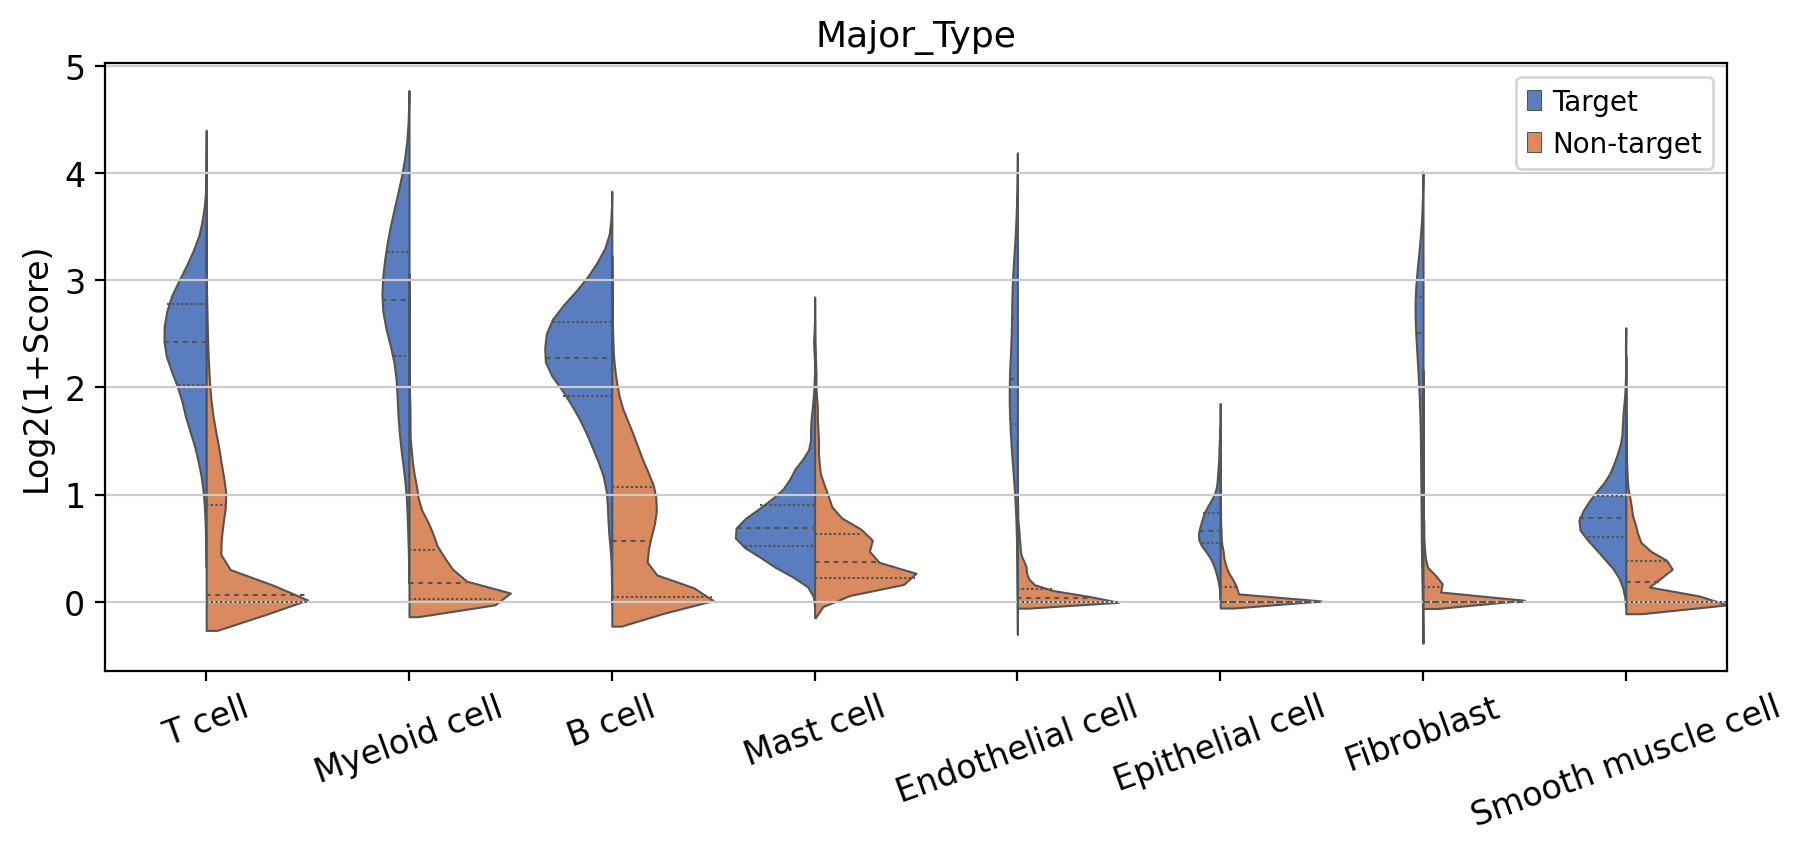

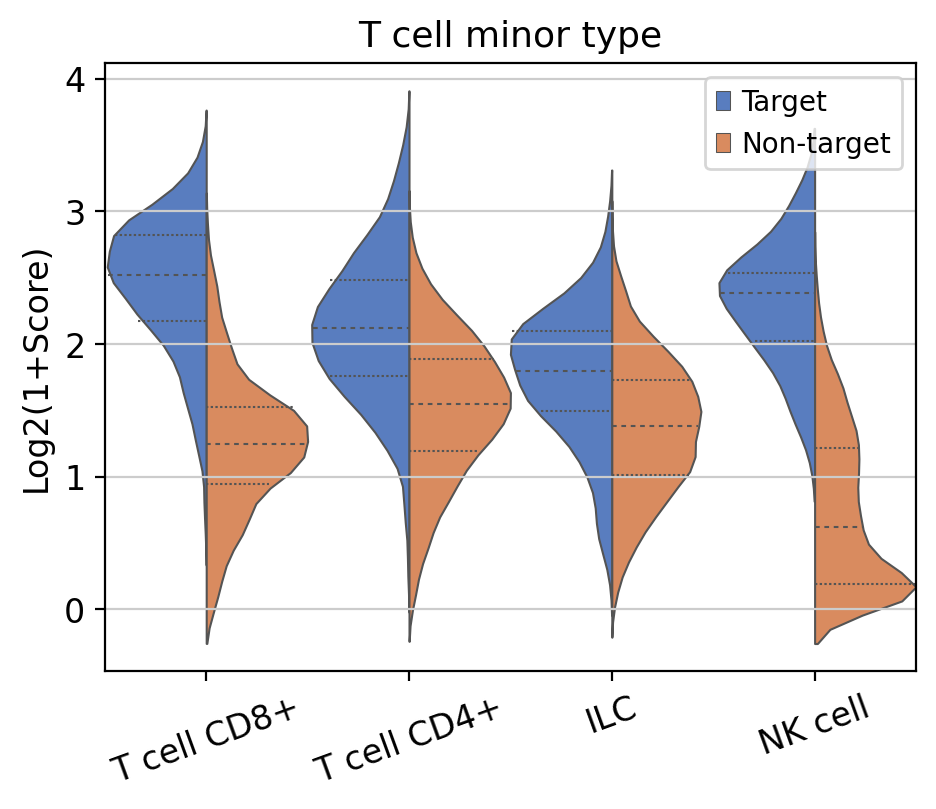

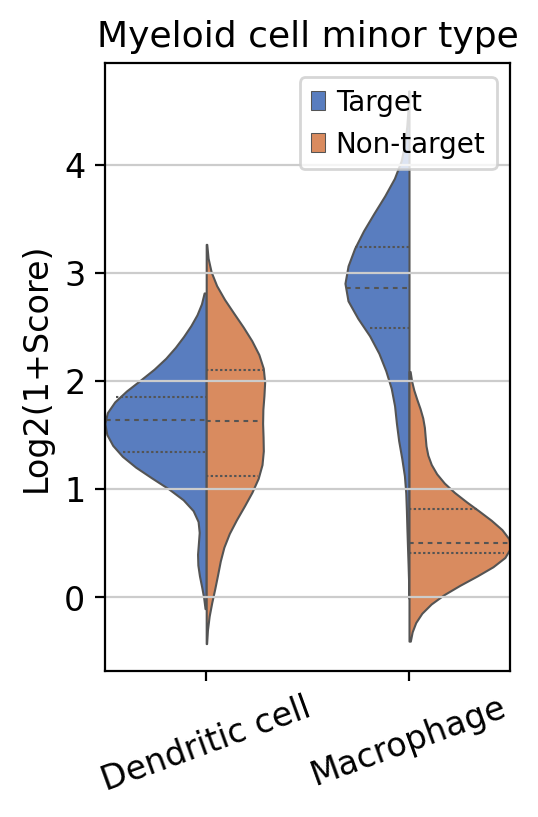

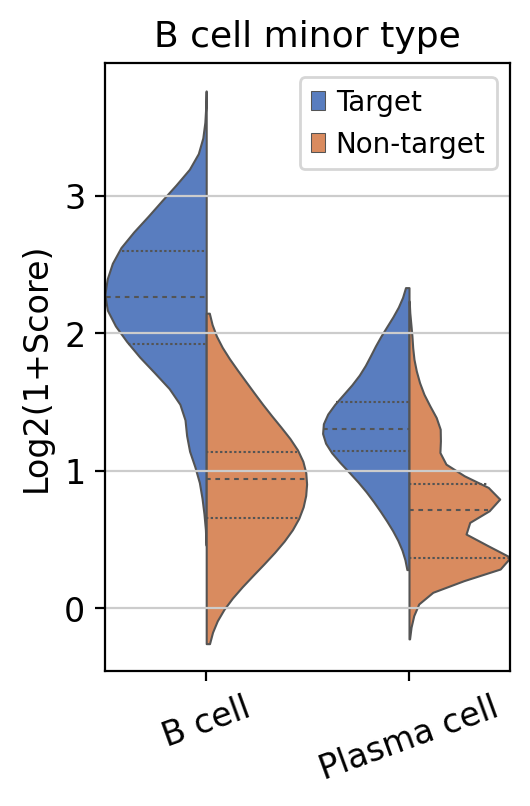

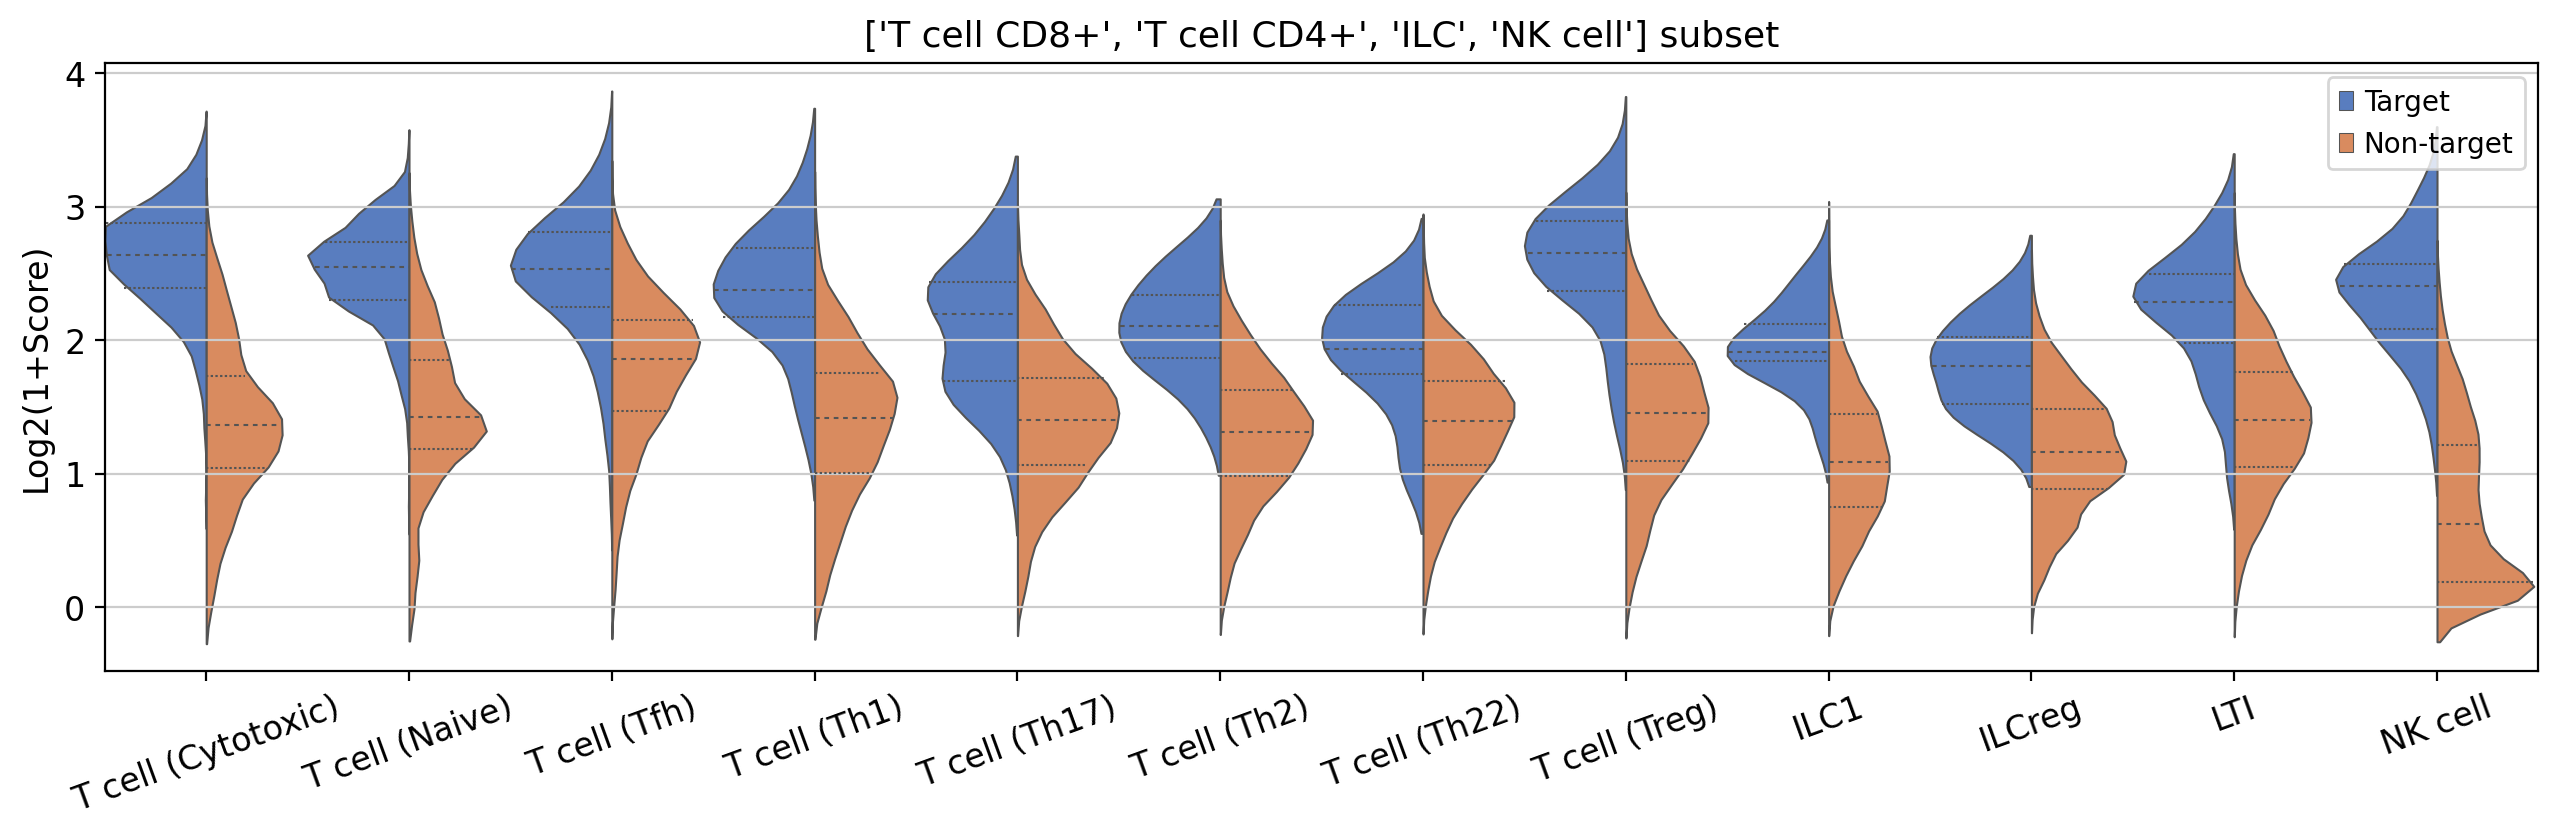

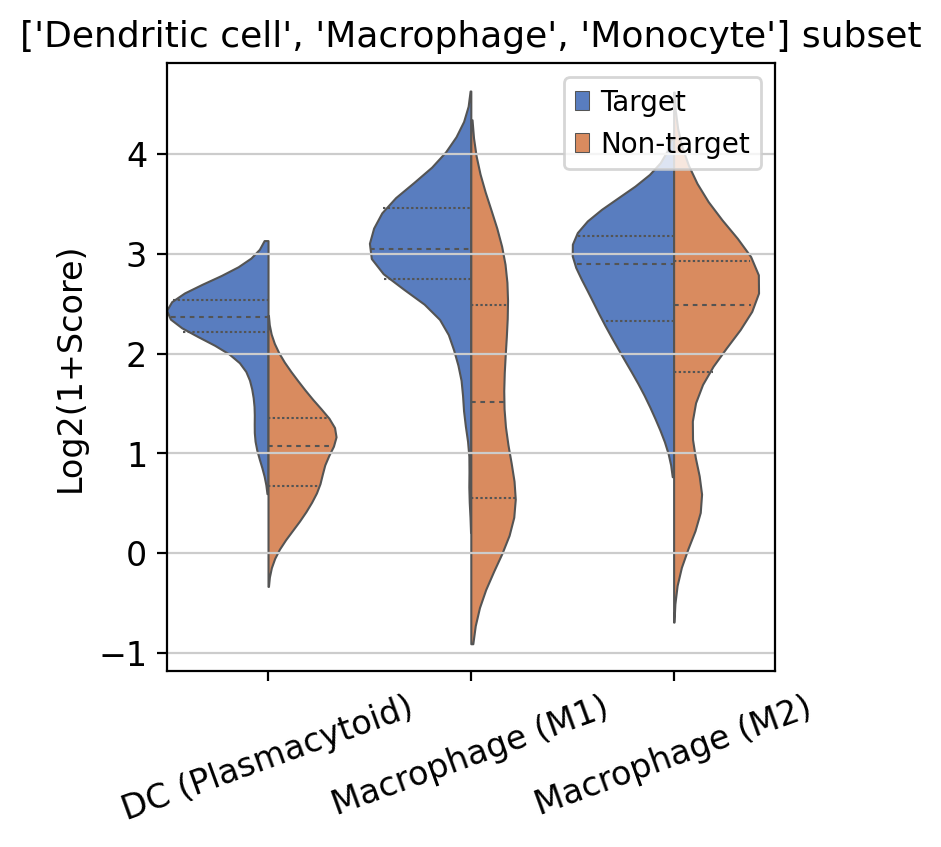

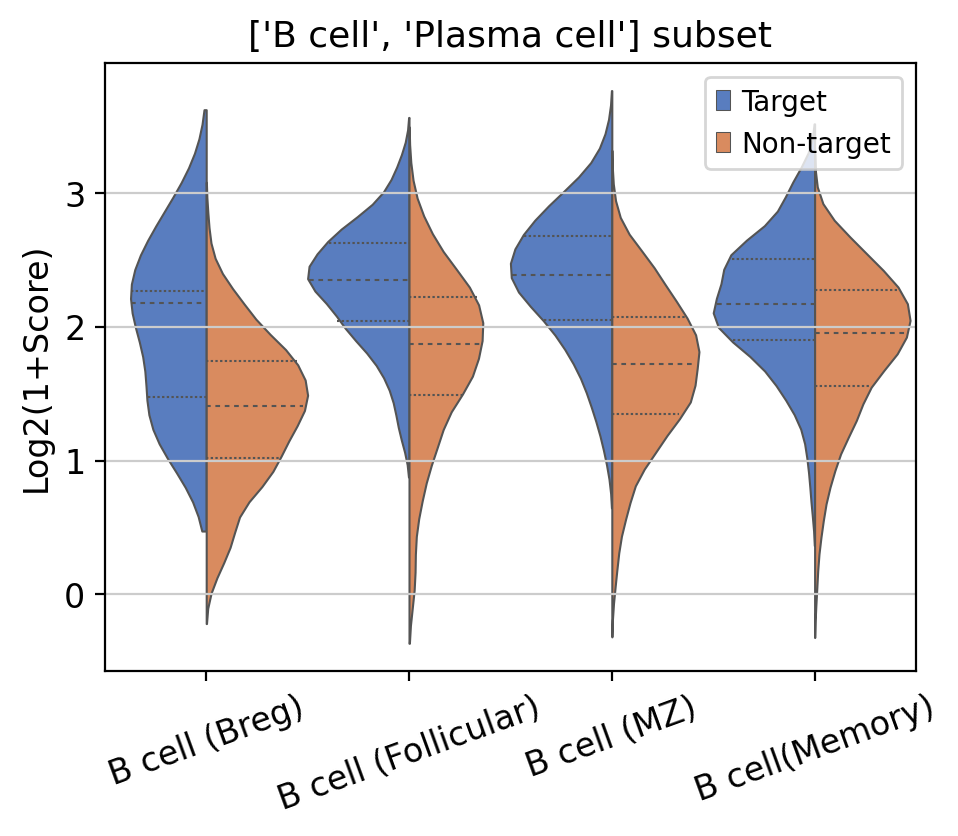

In [37]:
auc_lst = show_summary(df_pred, summary)